# Image Processing Assignment 2

<ul>
Bereket Eshete, Grad student <br>
University of Memphis, Spring 2022 <br>
Instructor: Dr. Yeasin <br>
    </ul>

## Question 1

### Histogram Equalization

Write computer programs to perform “Histogram Equalization” and “Histogram Specification” 
compare the performance of your program with the OpenCV output on same images.  Show 
where classic histogram equalization fails to produce desired results. Implement local histogram 
equalization. Show in some cases local histogram will do better job in improving the contrast of 
the image.

In [2]:
##################################################
# Import necessary libraries

import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from tqdm import tqdm
from skimage import data

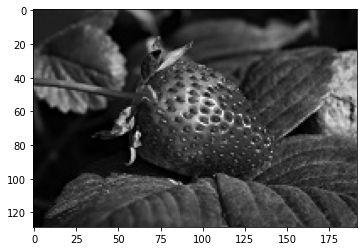

In [8]:
##################################################
# Histogram Equalization Implementation

img = cv2.imread('Data/straw_2.jpg', cv2.IMREAD_GRAYSCALE)

#plt.figure(figsize=(8,6))
plt.figure()
plt.imshow(img, cmap=cm.gray)

In [9]:
def get_hist_img(img):
    
    hist = np.zeros((256,), dtype=np.int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i,j]] += 1
            
    return hist

def histeq(img):
    
    hist = get_hist_img(img)
    hist_eq = np.zeros((256,), dtype=np.float64)
    eq_img = np.copy(img)
    MN = img.shape[0] * img.shape[1]
    for L,nk in enumerate(hist):
        prob = nk/MN
        if L == 0: 
            hist_eq[L] = L * prob
        else:
            hist_eq[L] = hist_eq[L-1] + L * prob
        indices = np.argwhere(eq_img == L)
        
        
        for i in indices:
            eq_img[i[0], i[1]] = round(hist_eq[L])
            
            
#     eq_img = ((eq_img - eq_img.min())/(eq_img.max() - eq_img.min())) * 255
#     eq_img = eq_img.astype(np.uint8)
    
    return get_hist_img(eq_img), eq_img, hist_eq.astype(int)

def local_histeq(img, kernel):
    M, N = img.shape
    x, y = kernel
    eq_img = np.copy(img)
    for i in range(0,M-x,x):
        for j in range(0,N-y,y):
            img_eq = np.copy(eq_img[i:i+x, j:j+y])
            
            _, eq_img[i:i+x, j:j+y], _ = histeq(img_eq)
    eq_img = scale_img(eq_img)      
    return eq_img

def hist_specify(img, ref_img):
    h_img, eq_img, lt_img = histeq(img)
    h_ref_img, eq_ref_img, lt_ref_img = histeq(ref_img)
    
    eq_spec_img = np.copy(eq_img)
    for L, eq_val_ref in zip(range(0,256), lt_ref_img):
        indices = np.argwhere(eq_spec_img == L)
        
        for i in indices:
            eq_spec_img[i[0], i[1]] = eq_val_ref
    
    eq_spec_img = ((eq_spec_img - eq_spec_img.min())/(eq_spec_img.max() - eq_spec_img.min())) * 255
    eq_spec_img = eq_spec_img.astype(np.uint8)
            
    return get_hist_img(eq_spec_img), eq_spec_img, h_ref_img

def apply_filter(img, kernel, kernel_type):
    M, N = img.shape
    x, y = kernel.shape
    e_img = np.copy(img)
    filtered_img = np.zeros((M,N))

    e_img = np.pad(e_img, [(0, x-1), (0, y-1)])

    
    if kernel_type == 'median':
        for i in range(M):
            for j in range(N):
                k_vals = e_img[i:i+x, j:j+y].flatten()
                med_val = np.median(k_vals)
                filtered_img[i,j] = med_val
                
    if kernel_type == 'mean':
        kernel = (1/np.sum(kernel))*kernel
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
                
    if kernel_type == 'filter':
        for i in range(M):
            for j in range(N):
                ip = np.multiply(e_img[i:i+x, j:j+y], kernel, dtype=np.float32)
                avg_val = np.sum(ip)
                filtered_img[i,j] = avg_val
    
    return scale_img(filtered_img)    

def plot_hist(hist):
    plt.figure(figsize=(8,6))
    plt.bar(list(range(0,256)), hist)
    plt.show()
    
def scale_img(img, qmin=0, qmax=255):
    max_val = img.max()
    min_val = img.min()
    scaled_img = ((img - min_val)/(max_val - min_val)) * (qmax - qmin)
    
    return scaled_img.astype(np.uint8)

C:\Users\CIRL\AppData\Local\Temp/ipykernel_18480/1068456144.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist = np.zeros((256,), dtype=np.int)


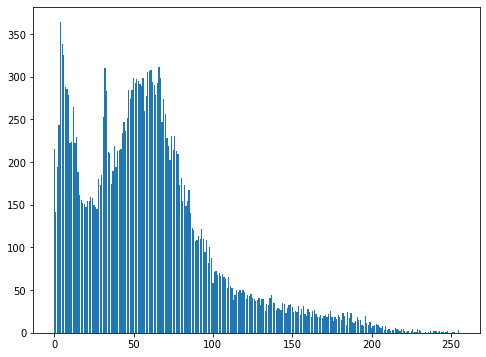

In [10]:
hist = get_hist_img(img)
plot_hist(hist)

C:\Users\CIRL\AppData\Local\Temp/ipykernel_18480/1068456144.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist = np.zeros((256,), dtype=np.int)


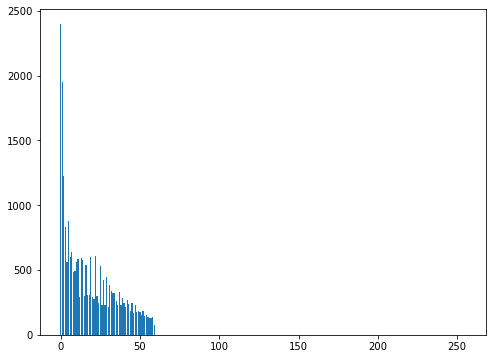

In [11]:
hist_eq, eq_img, lt = histeq(img)
plot_hist(hist_eq)

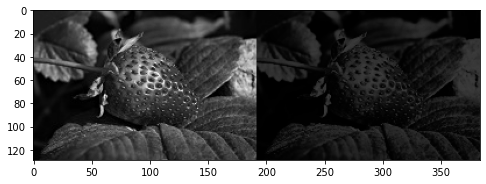

In [12]:
f_img = np.hstack((img, eq_img))
plt.figure(figsize=(8,6))
plt.imshow(f_img, cmap=cm.gray)

### Local Histogram Equalization

C:\Users\CIRL\AppData\Local\Temp/ipykernel_18480/1068456144.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hist = np.zeros((256,), dtype=np.int)


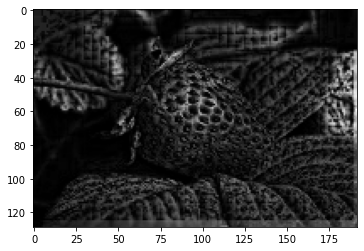

In [13]:
l_eq_img = local_histeq(img, (5,5))
plt.imshow(l_eq_img, cmap=cm.gray)

## Question 2

Instruction: Implement “Mean and Median Filter” in enhancing the quality of images.  Show the effect of 
different window sizes in your output and explain the results you observe in your reports.

(129, 192)

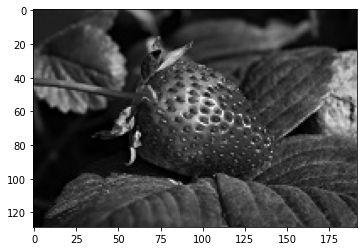

In [11]:
noisy_img = cv2.imread('data/straw_2.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(noisy_img, cmap=cm.gray)
noisy_img.shape

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:03<00:00,  2.16it/s]


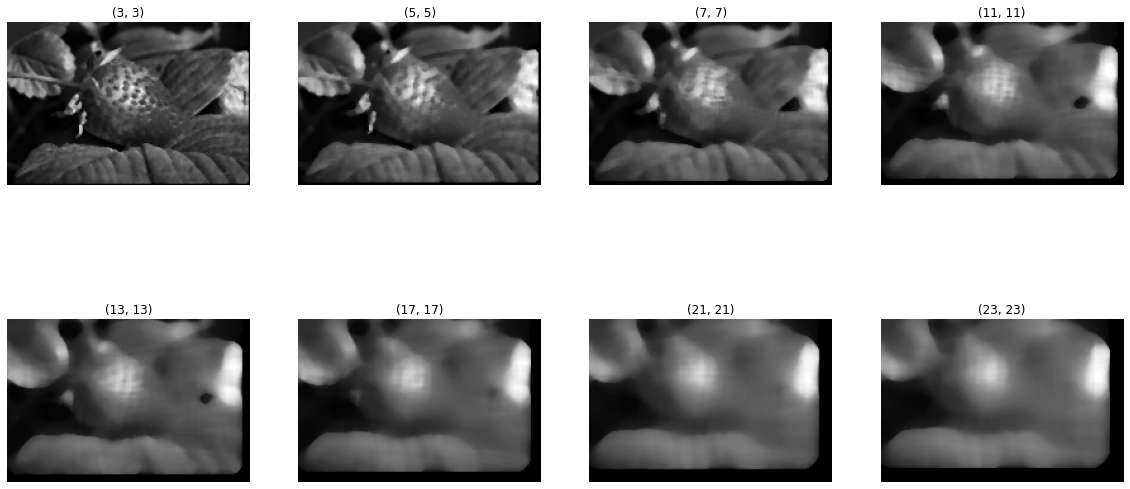

In [12]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.zeros(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'median'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  6.65it/s]


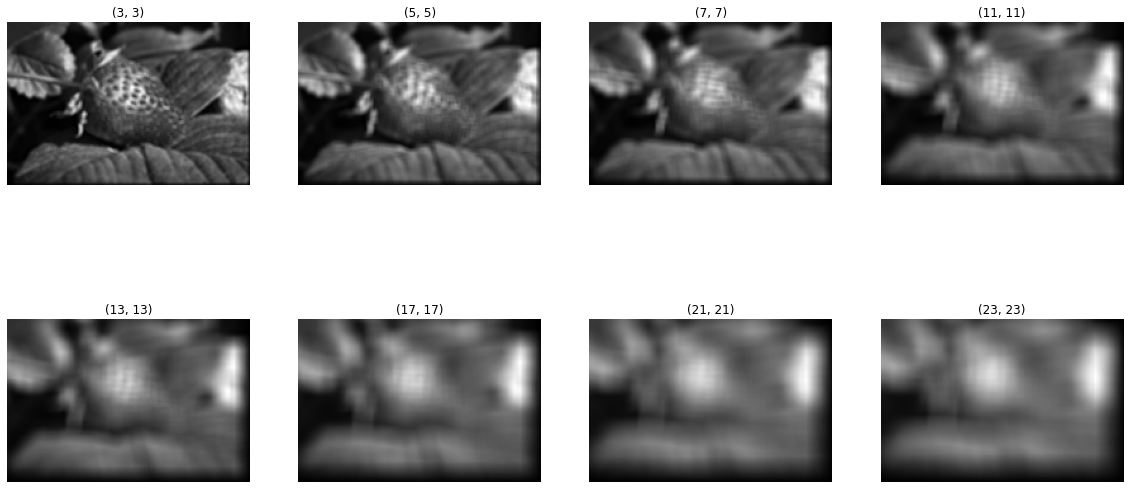

In [13]:
kernel_sizes = [(3,3), (5,5), (7,7), (11,11), (13, 13), (17,17), (21, 21), (23, 23)]
f_imgs = []

for kernel_size in tqdm(kernel_sizes):
    kernel = np.ones(kernel_size)
    f_imgs.append(apply_filter(noisy_img, kernel, 'mean'))
    
    
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,10))

for i, ax in zip(range(len(f_imgs)), axs.flatten()):
    ax.set_title(kernel_sizes[i])
    ax.imshow(f_imgs[i], cmap=cm.gray)
    ax.axis('off')

## Question 3

### High pass Filtering


Create the mask of simple 5x5 and 7x7 high pass filter. Apply the mask to enhance the finer 
details of the image. Modify the masks to perform “High Boost Filtering”. Make sure you don’t 
do more than one pass over the image.

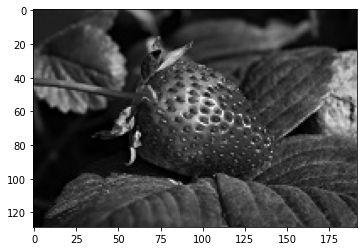

In [4]:
img = cv2.imread('data/straw_2.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap=cm.gray)

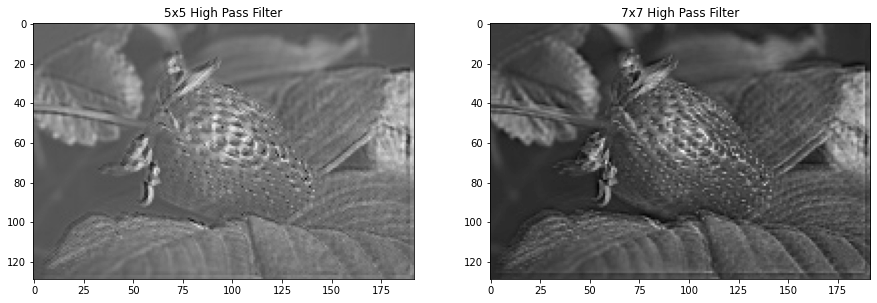

In [7]:
high_pass5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-2],
                      [-1,-4,22,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

high_pass7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-41,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

f_img5x5 = apply_filter(img, high_pass5x5_kernel, 'filter')
f_img7x7 = apply_filter(img, high_pass7x7_kernel, 'filter')

f_img5x5 = scale_img(np.add(img, -f_img5x5, dtype=np.float32))
f_img7x7 = scale_img(np.add(img, -f_img7x7, dtype=np.float32))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Pass Filter")
ax1.imshow(f_img5x5, cmap=cm.gray)

ax2.set_title("7x7 High Pass Filter")
ax2.imshow(f_img7x7, cmap=cm.gray)

In [8]:
high_pass5x5_kernel

array([[ 0, -1, -1, -1,  0],
       [-1,  2, -4,  2, -2],
       [-1, -4, 22, -4, -1],
       [-1,  2, -4,  2, -1],
       [ 0, -1, -1, -1,  0]])

In [9]:
high_pass7x7_kernel

array([[  1,   0,   0,   1,   0,   0,   1],
       [  0,   2,   0,   2,   0,   2,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   0,   0, -41,   0,   0,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   2,   0,   2,   0,   2,   0],
       [  1,   0,   0,   1,   0,   0,   1]])

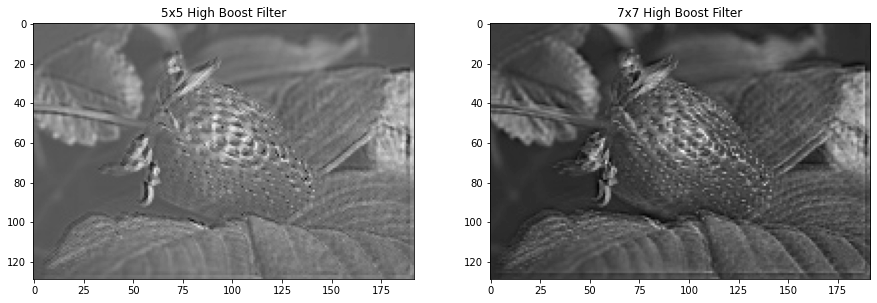

In [10]:
high_boost5x5_kernel = np.array([[0,-1,-1,-1,0],
                      [-1,2,-4,2,-2],
                      [-1,-4,23,-4,-1],
                      [-1,2,-4,2,-1],
                      [0,-1,-1,-1,0]])

high_boost7x7_kernel = np.array([[1,0,0,1,0,0,1],
                      [0,2,0,2,0,2,0],
                      [0,0,4,4,4,0,0],
                      [0,0,0,-40,0,0,0],
                      [0,0,4,4,4,0,0],
                      [0,2,0,2,0,2,0],
                      [1,0,0,1,0,0,1]])

f_img5x5 = apply_filter(img, high_boost5x5_kernel, 'filter')
f_img7x7 = apply_filter(img, high_boost7x7_kernel, 'filter')

f_img5x5 = scale_img(np.add(img, -f_img5x5, dtype=np.float32))
f_img7x7 = scale_img(np.add(img, -f_img7x7, dtype=np.float32))

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,15))

ax1.set_title("5x5 High Boost Filter")
ax1.imshow(f_img5x5, cmap=cm.gray)

ax2.set_title("7x7 High Boost Filter")
ax2.imshow(f_img7x7, cmap=cm.gray)

In [11]:
high_boost5x5_kernel

array([[ 0, -1, -1, -1,  0],
       [-1,  2, -4,  2, -2],
       [-1, -4, 23, -4, -1],
       [-1,  2, -4,  2, -1],
       [ 0, -1, -1, -1,  0]])

In [12]:
high_boost7x7_kernel

array([[  1,   0,   0,   1,   0,   0,   1],
       [  0,   2,   0,   2,   0,   2,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   0,   0, -40,   0,   0,   0],
       [  0,   0,   4,   4,   4,   0,   0],
       [  0,   2,   0,   2,   0,   2,   0],
       [  1,   0,   0,   1,   0,   0,   1]])

## Question 4

### Edge detecting using sobel operator

Instruction: Implement Horizontal, vertical and diagonal edge detector using Sobel operator. Explain the 
results in your report.

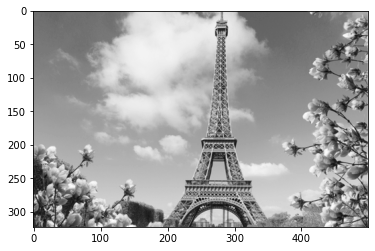

In [3]:
img = cv2.imread('data/paris.jpg', cv2.IMREAD_GRAYSCALE)

plt.imshow(img, cmap=cm.gray)

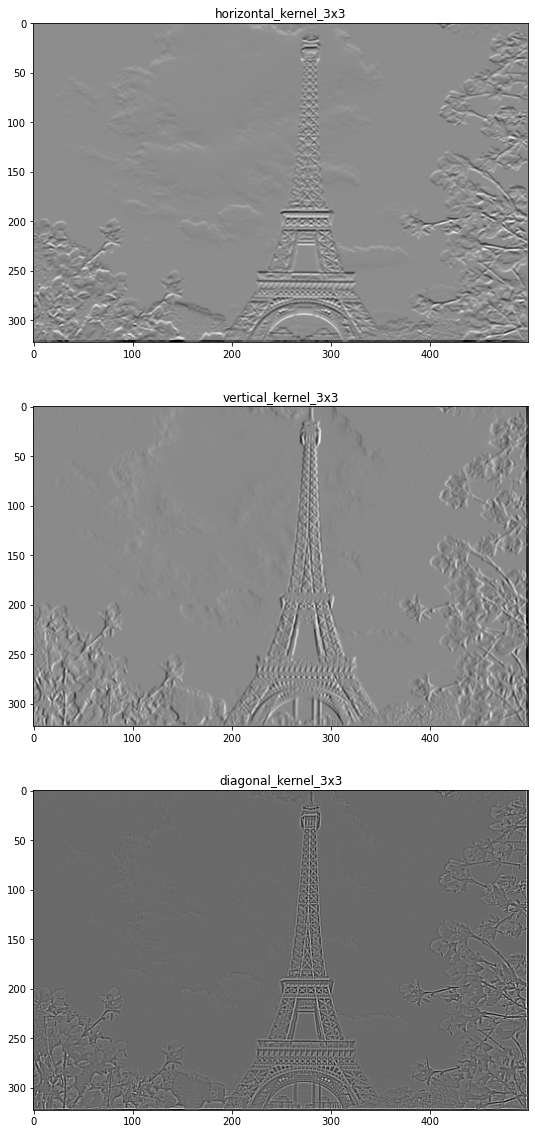

In [6]:
horizontal_kernel3x3 = np.array([[-1,-2,-1],
                     [0,0,0],
                     [1,2,1]])
vertical_kernel3x3 = np.array([[-1,0,1],
                     [-2,0,2],
                     [-1,0,1]])

diagonal_kernel3x3 = np.array([[-1,0,-1],
                     [0,4,0],
                     [-1,0,-1]])

f_img_h = apply_filter(img, horizontal_kernel3x3, 'filter')
f_img_v = apply_filter(img, vertical_kernel3x3, 'filter')
f_img_d = apply_filter(img, diagonal_kernel3x3, 'filter')

fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(20,20))

ax1.set_title("horizontal_kernel_3x3")
ax1.imshow(f_img_h, cmap=cm.gray)

ax2.set_title("vertical_kernel_3x3")
ax2.imshow(f_img_v, cmap=cm.gray)

ax3.set_title("diagonal_kernel_3x3")
ax3.imshow(f_img_d, cmap=cm.gray)

#### Reference:

[1] Paris Image: https://www.frommers.com/system/media_items/attachments/000/866/648/s500/Eiffel_Tower_Paris_France.jpg?1613010378  <br>